In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [22]:
data = np.load("data_shrunk.npy", allow_pickle=True)
print(f"Dataset loaded with {len(data)} workouts")

Dataset loaded with 10300 workouts


In [4]:
# Create a function to extract workout data into a more usable format
def extract_workout_data(workout):
    """Extract key metrics from a workout and return as a dictionary"""
    
    # Basic metadata
    workout_data = {
        'user_id': workout.get('userId', 'unknown'),
        'sport': workout.get('sport', 'unknown'),
        'gender': workout.get('gender', 'unknown'),
        'workout_id': workout.get('id', 'unknown')
    }
    
    # Extract heart rate data
    if 'tar_heart_rate' in workout and len(workout['tar_heart_rate']) > 0:
        hr_values = workout['tar_heart_rate']
        # Filter out likely invalid heart rate values (e.g., zeros or extremely high values)
        valid_hr = [hr for hr in hr_values if 30 < hr < 220]
        
        if valid_hr:
            workout_data.update({
                'avg_hr': np.mean(valid_hr),
                'max_hr': np.max(valid_hr),
                'min_hr': np.min(valid_hr),
                'hr_std': np.std(valid_hr),
                'hr_values': valid_hr,
                'hr_count': len(valid_hr)
            })
    
    # Extract speed data
    if 'tar_derived_speed' in workout and len(workout['tar_derived_speed']) > 0:
        speed_values = workout['tar_derived_speed']
        # Filter out negative or unreasonably high speeds
        valid_speed = [s for s in speed_values if 0 <= s < 30]  # 30 m/s = 108 km/h
        
        if valid_speed:
            workout_data.update({
                'avg_speed': np.mean(valid_speed),
                'max_speed': np.max(valid_speed),
                'speed_std': np.std(valid_speed),
                'speed_values': valid_speed,
                'speed_count': len(valid_speed)
            })
    
    # Extract distance data
    if 'distance' in workout:
        # Calculate total distance (might need processing depending on dataset structure)
        distance_values = workout['distance']
        if len(distance_values) > 1:
            # Use the maximum value as the total distance
            # Adjust if your distance is cumulative or needs other processing
            total_distance = np.max(distance_values)
            workout_data['total_distance'] = total_distance
    
    # Extract timestamp/duration data
    if 'timestamp' in workout:
        timestamps = workout['timestamp']
        if len(timestamps) > 1:
            # Calculate duration in seconds
            duration = timestamps[-1] - timestamps[0]
            workout_data['duration'] = duration
    
    # Extract altitude data if available
    if 'altitude' in workout:
        altitude_values = workout['altitude']
        valid_alt = [a for a in altitude_values if not np.isnan(a)]
        
        if valid_alt:
            alt_diff = np.diff(valid_alt)
            total_ascent = sum(diff for diff in alt_diff if diff > 0)
            total_descent = sum(abs(diff) for diff in alt_diff if diff < 0)
            
            workout_data.update({
                'total_ascent': total_ascent,
                'total_descent': total_descent,
                'altitude_range': np.max(valid_alt) - np.min(valid_alt),
            })
    
    return workout_data

In [5]:
# Process all workouts to extract key metrics
print("Extracting workout data...")
all_workouts = []
skipped_count = 0

Extracting workout data...


In [6]:
# Process each workout
for i, workout in enumerate(data):
    if i % 1000 == 0:
        print(f"Processing workout {i}/{len(data)}...", end='\r')
    
    # Extract workout data
    workout_data = extract_workout_data(workout)
    
    # Only add workouts with heart rate data
    if 'avg_hr' in workout_data:
        all_workouts.append(workout_data)
    else:
        skipped_count += 1

print(f"\nProcessed {len(all_workouts)} workouts with valid heart rate data (skipped {skipped_count})")

Processing workout 10000/10300...
Processed 10300 workouts with valid heart rate data (skipped 0)


In [7]:
# Convert to DataFrame for easier analysis
workouts_df = pd.DataFrame(all_workouts)
print("\nWorkout data sample:")
workouts_df.head()

# Basic statistics of the dataset
print("\nBasic statistics of numeric columns:")
workouts_df.describe()


Workout data sample:

Basic statistics of numeric columns:


,user_id,workout_id,avg_hr,max_hr,min_hr,hr_std,hr_count,avg_speed,max_speed,speed_std,speed_count,total_distance,duration,total_ascent,total_descent,altitude_range
count,1.030000e+04,1.030000e+04,10300.000000,10300.000000,10300.000000,10300.000000,10300.0,1.030000e+04,1.030000e+04,1.030000e+04,10300.000000,10300.000000,10300.000000,1.030000e+04,10300.000000,1.030000e+04
mean,4.580786e+06,3.646750e+08,136.889628,160.869674,84.608167,12.924241,300.0,1.623533e+01,2.400270e+01,4.114774e+00,245.862816,28.555214,3810.878641,2.153945e+00,2.016281,1.065041e+00
std,3.873885e+06,1.598179e+08,16.717323,16.398259,17.423462,5.277905,0.0,6.750732e+00,7.512219e+00,2.341809e+00,67.575843,288.901266,1919.181117,1.768137e+00,5.205745,5.123920e+00
min,6.900000e+01,1.346428e+06,71.047674,74.037743,50.000000,0.000000,300.0,6.065609e-16,7.105427e-15,1.550070e-15,3.000000,-4.372304,955.000000,1.812786e-16,0.000000,4.336809e-18
25%,1.520156e+06,2.610196e+08,126.433655,150.888287,72.389325,8.948805,300.0,1.073364e+01,1.685467e+01,1.777446e+00,213.000000,2.352718,2369.750000,1.004291e+00,0.983522,3.449663e-01
50%,3.411439e+06,3.602070e+08,137.771864,161.999097,83.000000,12.165599,300.0,1.619559e+01,2.950859e+01,4.355217e+00,277.000000,9.559806,3190.000000,1.779320e+00,1.679905,6.496526e-01
75%,7.038373e+06,4.855019e+08,148.124546,172.000000,95.000000,16.015061,300.0,2.263993e+01,2.994293e+01,5.871924e+00,298.000000,22.385158,4639.250000,2.879940e+00,2.598761,1.160223e+00
max,1.532664e+07,6.740080e+08,189.800979,200.000000,167.999979,45.384666,300.0,2.854941e+01,3.000000e+01,1.357871e+01,300.000000,18189.529064,15725.000000,6.235048e+01,504.918444,5.040136e+02


In [8]:
# Count workouts by sport type
print("\nWorkouts by sport type:")
sport_counts = workouts_df['sport'].value_counts()
print(sport_counts)


Workouts by sport type:
sport
bike                       4860
run                        3908
mountain bike               787
bike (transport)            324
indoor cycling              134
walk                         64
cross-country skiing         59
orienteering                 43
roller skiing                21
core stability training      20
fitness walking              19
hiking                       16
skate                        13
kayaking                      6
soccer                        4
rowing                        4
weight training               4
downhill skiing               3
circuit training              3
snowshoeing                   3
tennis                        1
table tennis                  1
golf                          1
treadmill running             1
horseback riding              1
Name: count, dtype: int64


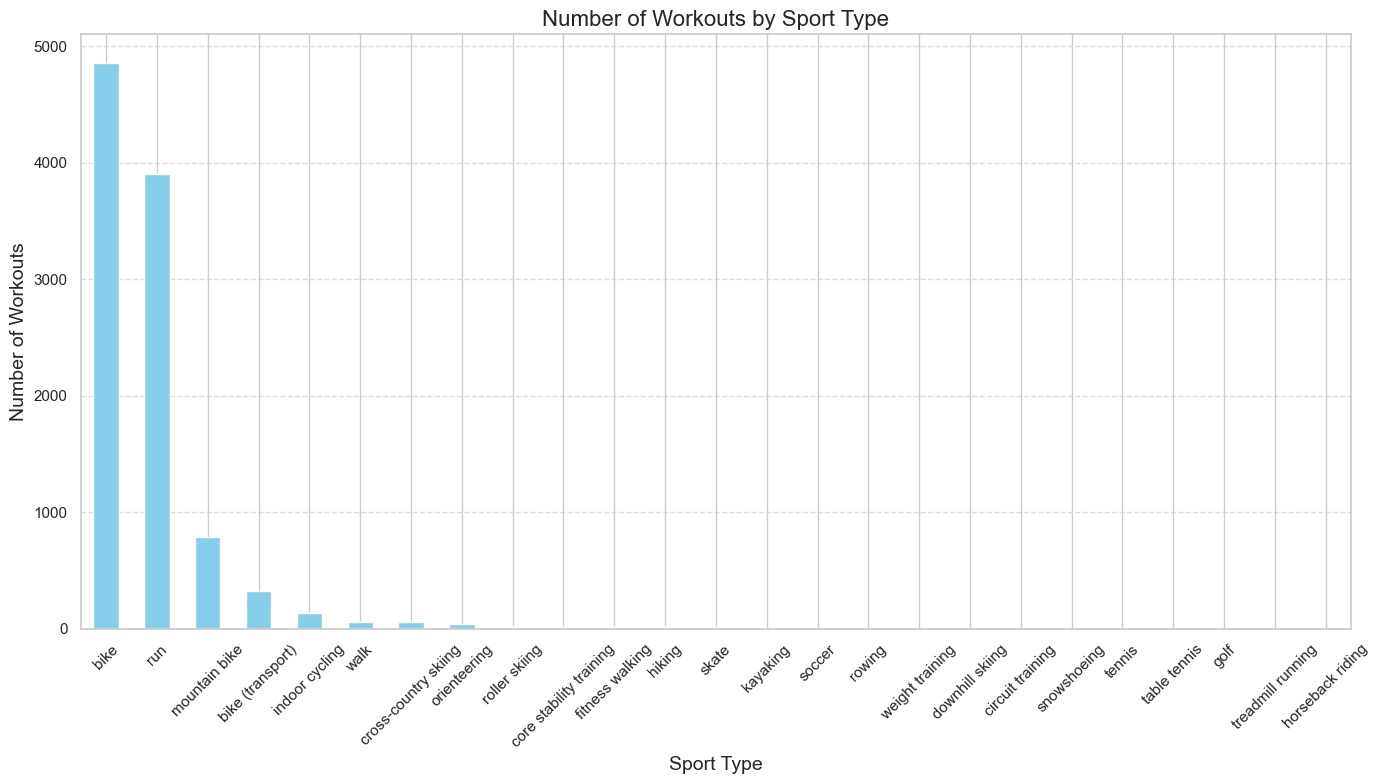

In [9]:
# Display in a bar chart
plt.figure(figsize=(14, 8))
sport_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Workouts by Sport Type', fontsize=16)
plt.xlabel('Sport Type', fontsize=14)
plt.ylabel('Number of Workouts', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

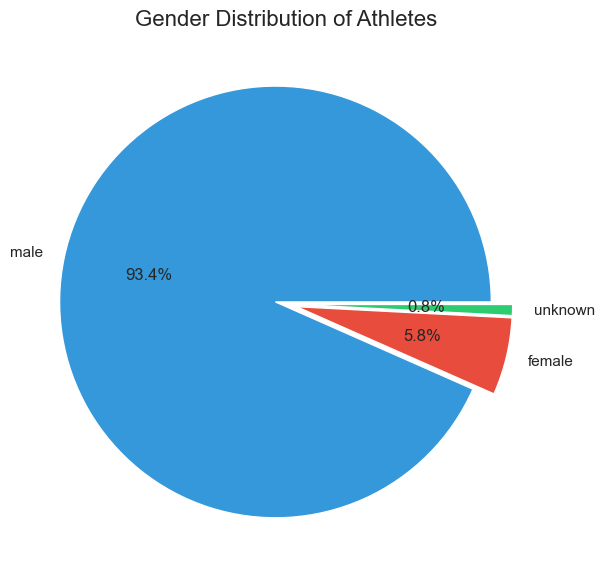

In [9]:
# Gender distribution
if 'gender' in workouts_df.columns:
    gender_counts = workouts_df['gender'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
            colors=['#3498db', '#e74c3c', '#2ecc71'], explode=[0.05, 0.05, 0.05])
    plt.title('Gender Distribution of Athletes', fontsize=16)
    plt.tight_layout()
    plt.show()

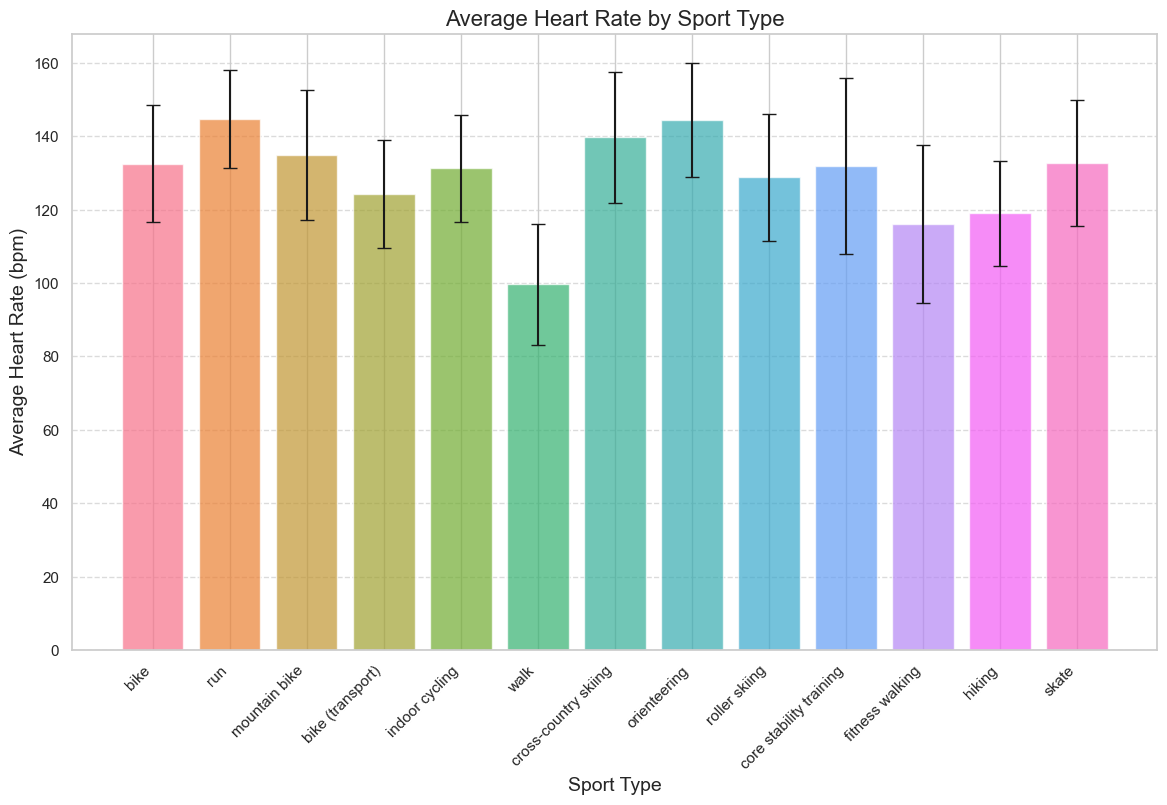

In [10]:
# 1. Analysis of Heart Rate by Sport Type

# Calculate average heart rate by sport
hr_by_sport = workouts_df.groupby('sport')['avg_hr'].agg(['mean', 'std', 'count']).sort_values('count', ascending=False)
hr_by_sport = hr_by_sport[hr_by_sport['count'] >= 10]  # Filter out sports with too few samples

# Create a color map for consistent sport colors
sport_colors = {}
color_palette = sns.color_palette('husl', n_colors=len(hr_by_sport))
for i, sport in enumerate(hr_by_sport.index):
    sport_colors[sport] = color_palette[i]

plt.figure(figsize=(14, 8))
bars = plt.bar(hr_by_sport.index, hr_by_sport['mean'], 
               yerr=hr_by_sport['std'], capsize=5, 
               color=[sport_colors[s] for s in hr_by_sport.index],
               alpha=0.7)

plt.title('Average Heart Rate by Sport Type', fontsize=16)
plt.xlabel('Sport Type', fontsize=14)
plt.ylabel('Average Heart Rate (bpm)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

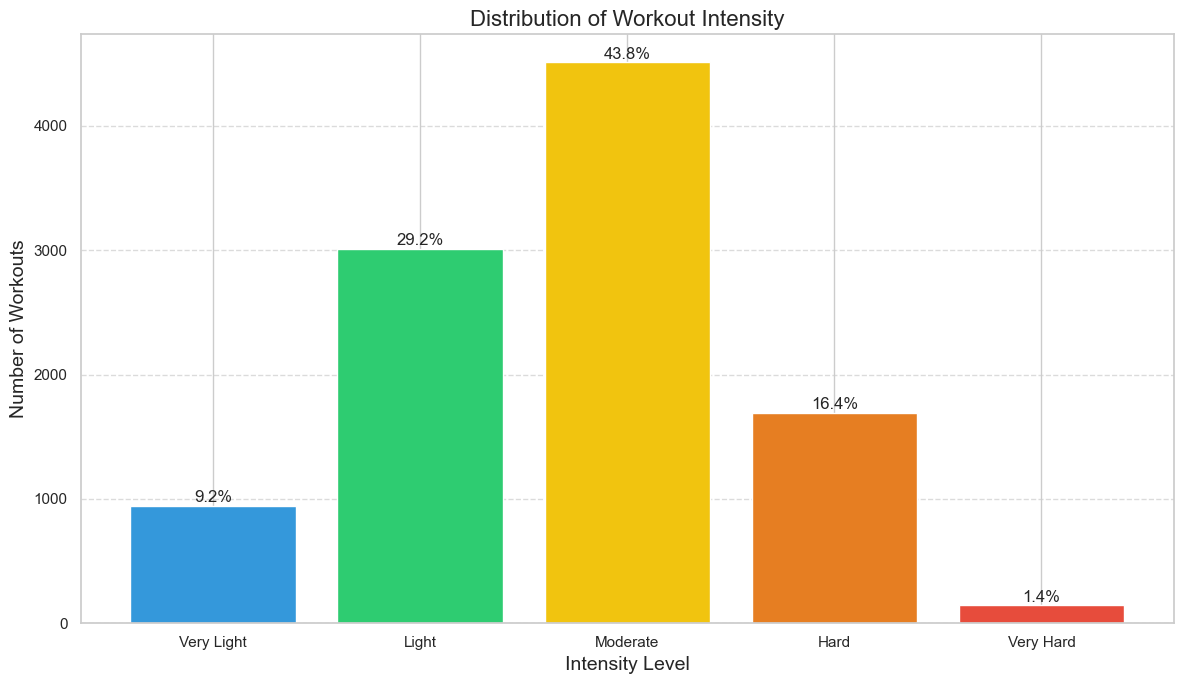

In [11]:
# 2. Workout Intensity Analysis

# Define a function to classify workout intensity based on heart rate
def classify_intensity(avg_hr, max_hr=190):  # Using a generic max HR, adjust if needed
    hr_percent = avg_hr / max_hr * 100
    if hr_percent < 60:
        return 'Very Light'
    elif hr_percent < 70:
        return 'Light'
    elif hr_percent < 80:
        return 'Moderate'
    elif hr_percent < 90:
        return 'Hard'
    else:
        return 'Very Hard'

# Add intensity classification to the dataframe
workouts_df['intensity'] = workouts_df['avg_hr'].apply(classify_intensity)

# Analyze intensity distribution
intensity_order = ['Very Light', 'Light', 'Moderate', 'Hard', 'Very Hard']
intensity_counts = workouts_df['intensity'].value_counts().reindex(intensity_order)

plt.figure(figsize=(12, 7))
bars = plt.bar(intensity_counts.index, intensity_counts.values, 
               color=['#3498db', '#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])

plt.title('Distribution of Workout Intensity', fontsize=16)
plt.xlabel('Intensity Level', fontsize=14)
plt.ylabel('Number of Workouts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels
total = intensity_counts.sum()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5,
             f'{height/total*100:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

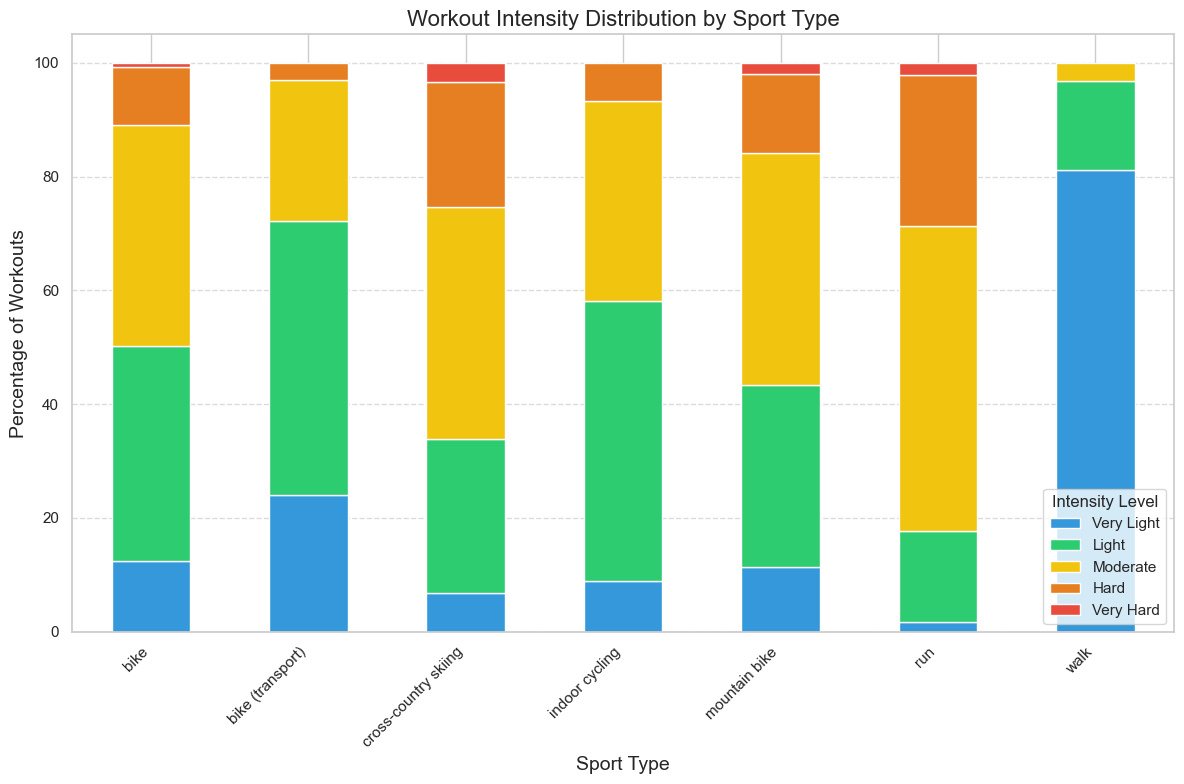

In [12]:
# 3. Intensity Distribution by Sport Type

# Calculate the percentage of each intensity level for top sports
top_sports = sport_counts[sport_counts >= 50].index.tolist()  # Focus on sports with enough data
intensity_by_sport = pd.crosstab(
    workouts_df[workouts_df['sport'].isin(top_sports)]['sport'], 
    workouts_df[workouts_df['sport'].isin(top_sports)]['intensity'],
    normalize='index'
) * 100

# Ensure all columns are present, even if some sports don't have certain intensities
for level in intensity_order:
    if level not in intensity_by_sport.columns:
        intensity_by_sport[level] = 0

# Reorder columns for consistent ordering
intensity_by_sport = intensity_by_sport.reindex(columns=intensity_order)

plt.figure(figsize=(14, 10))
intensity_by_sport.plot(kind='bar', stacked=True, 
                      color=['#3498db', '#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])

plt.title('Workout Intensity Distribution by Sport Type', fontsize=16)
plt.xlabel('Sport Type', fontsize=14)
plt.ylabel('Percentage of Workouts', fontsize=14)
plt.legend(title='Intensity Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

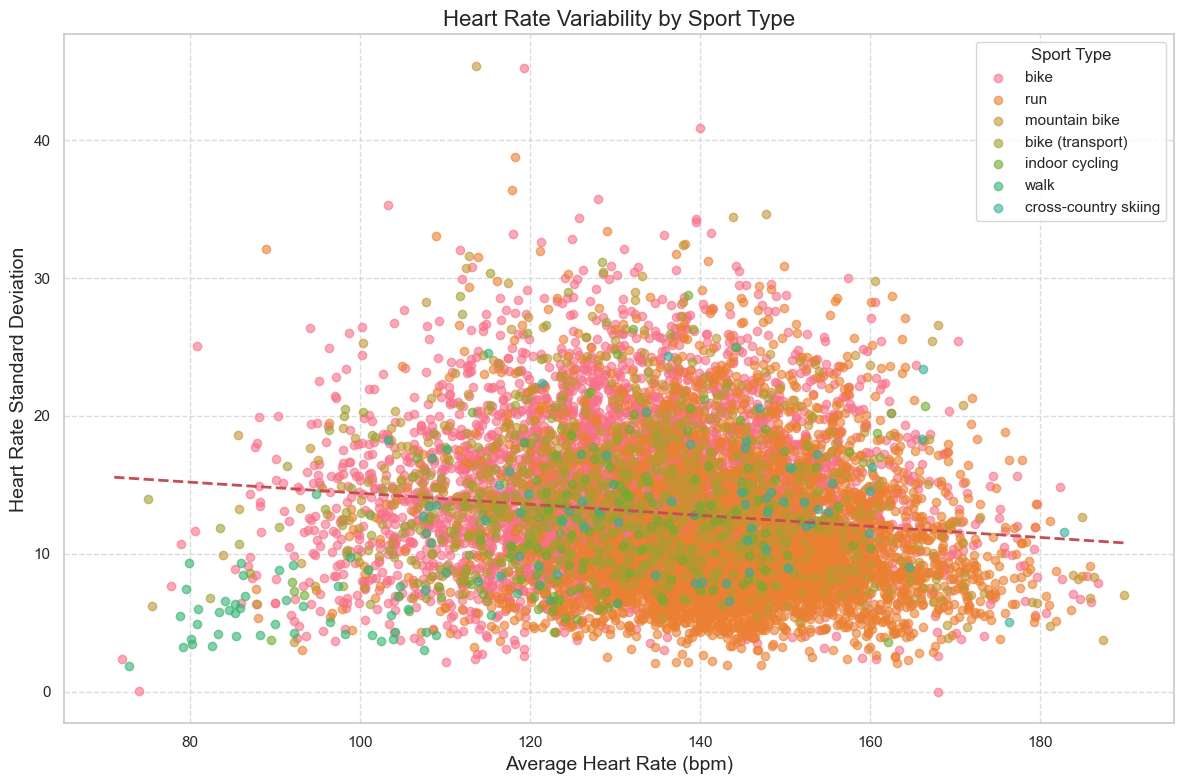

In [13]:
# 4. Heart Rate Variability Analysis

# Create a scatter plot of average HR vs standard deviation
plt.figure(figsize=(12, 8))
for sport in top_sports:
    sport_data = workouts_df[workouts_df['sport'] == sport]
    plt.scatter(sport_data['avg_hr'], sport_data['hr_std'], 
                label=sport, color=sport_colors.get(sport, 'gray'), alpha=0.6)

plt.title('Heart Rate Variability by Sport Type', fontsize=16)
plt.xlabel('Average Heart Rate (bpm)', fontsize=14)
plt.ylabel('Heart Rate Standard Deviation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Sport Type')

# Add trend line for the entire dataset
z = np.polyfit(workouts_df['avg_hr'], workouts_df['hr_std'], 1)
p = np.poly1d(z)
plt.plot(sorted(workouts_df['avg_hr'].unique()), 
         p(sorted(workouts_df['avg_hr'].unique())), 
         'r--', linewidth=2, label='Trend Line')

plt.tight_layout()
plt.show()

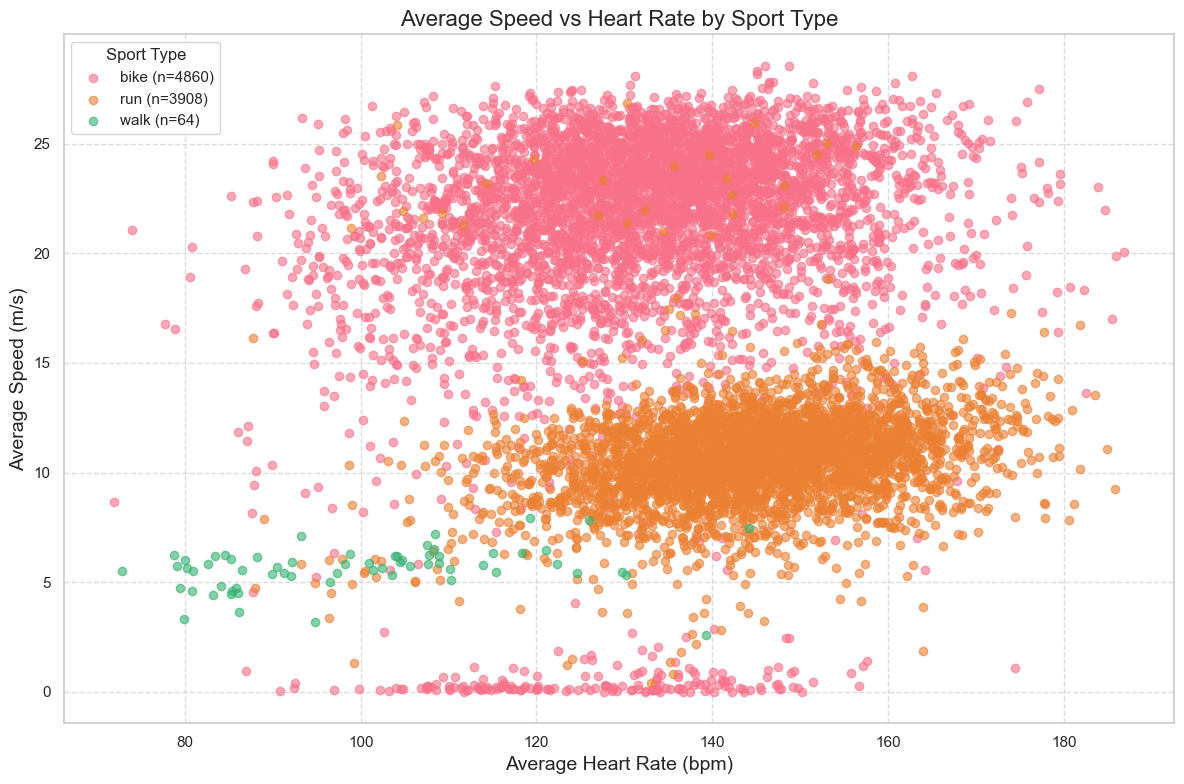

In [14]:
# 5. Performance Analysis (Speed vs Heart Rate)

# Filter for workouts that have both heart rate and speed data
speed_hr_df = workouts_df.dropna(subset=['avg_hr', 'avg_speed'])

plt.figure(figsize=(12, 8))
for sport in top_sports:
    if sport in ['run', 'bike', 'walk']:  # Focus on sports where speed is relevant
        sport_data = speed_hr_df[speed_hr_df['sport'] == sport]
        if len(sport_data) > 10:  # Only plot if we have enough data
            plt.scatter(sport_data['avg_hr'], sport_data['avg_speed'], 
                        label=f"{sport} (n={len(sport_data)})", 
                        color=sport_colors.get(sport, 'gray'), alpha=0.6)

plt.title('Average Speed vs Heart Rate by Sport Type', fontsize=16)
plt.xlabel('Average Heart Rate (bpm)', fontsize=14)
plt.ylabel('Average Speed (m/s)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Sport Type')
plt.tight_layout()
plt.show()

In [15]:
# Calculate correlation between HR and speed for each sport
correlations = {}
for sport in top_sports:
    if sport in ['run', 'bike', 'walk']:
        sport_data = speed_hr_df[speed_hr_df['sport'] == sport]
        if len(sport_data) > 10:
            corr = sport_data['avg_hr'].corr(sport_data['avg_speed'])
            correlations[sport] = corr

print("Correlation between heart rate and speed:")
for sport, corr in correlations.items():
    print(f"{sport}: {corr:.3f}")

Correlation between heart rate and speed:
bike: 0.152
run: 0.216
walk: 0.291


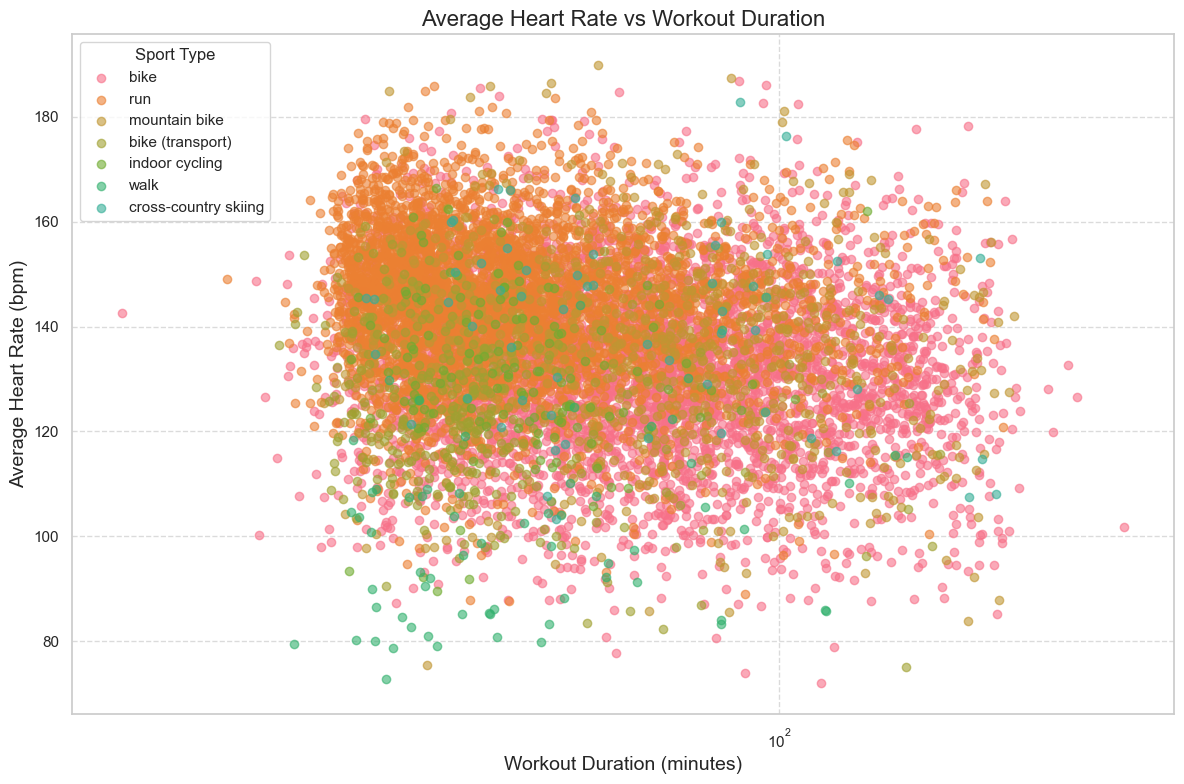

In [16]:
# 6. Time Series Analysis - Workout Duration vs Heart Rate

# Filter for workouts with duration data
duration_df = workouts_df.dropna(subset=['duration', 'avg_hr'])
duration_df['duration_min'] = duration_df['duration'] / 60  # Convert to minutes

plt.figure(figsize=(12, 8))
for sport in top_sports:
    sport_data = duration_df[duration_df['sport'] == sport]
    if len(sport_data) > 10:
        plt.scatter(sport_data['duration_min'], sport_data['avg_hr'], 
                    label=sport, color=sport_colors.get(sport, 'gray'), alpha=0.6)

plt.title('Average Heart Rate vs Workout Duration', fontsize=16)
plt.xlabel('Workout Duration (minutes)', fontsize=14)
plt.ylabel('Average Heart Rate (bpm)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Sport Type')
plt.xscale('log')  # Log scale for better visualization of duration
plt.tight_layout()
plt.show()

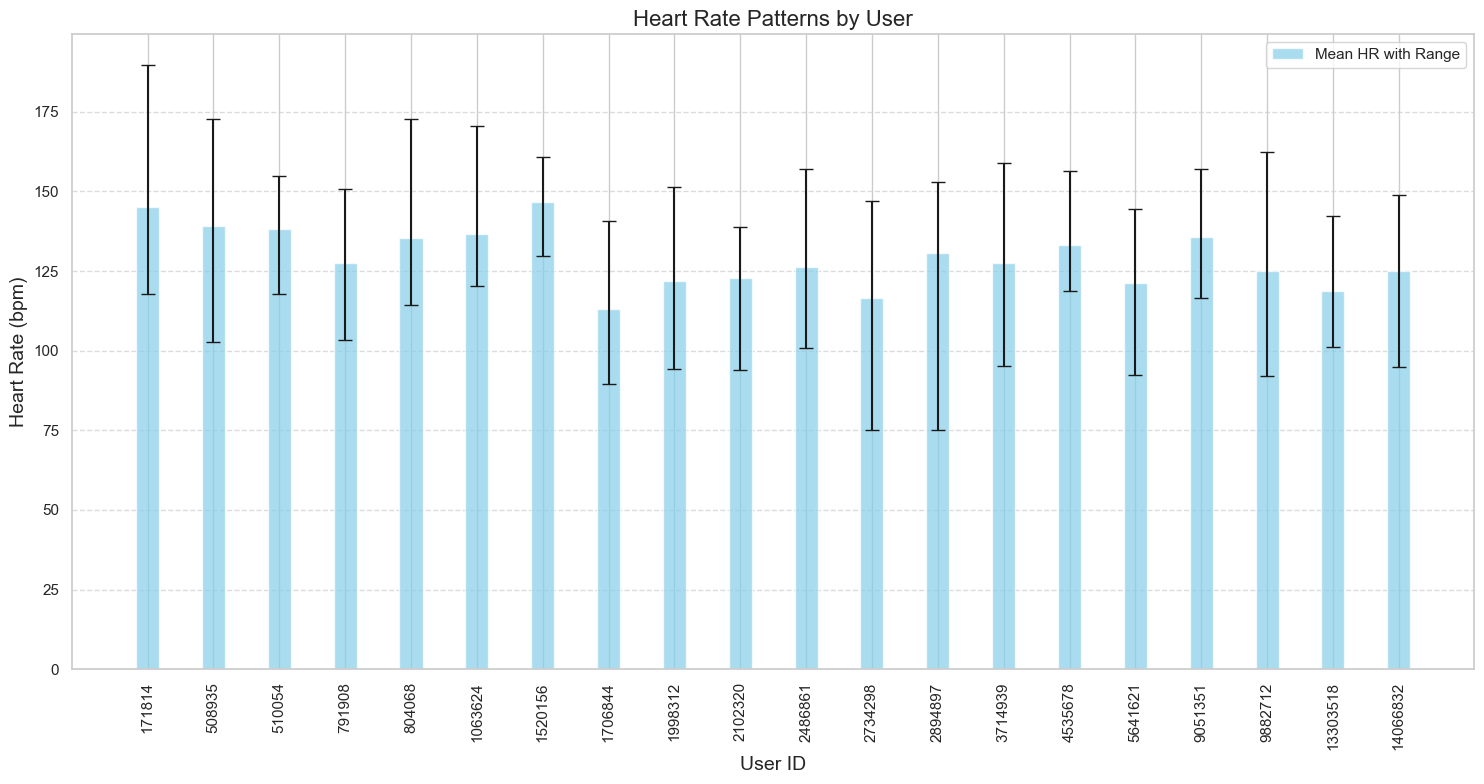

In [17]:
# 7. User Analysis - Heart Rate Patterns by User

# Get users with multiple workouts
user_counts = workouts_df['user_id'].value_counts()
users_with_multiple = user_counts[user_counts >= 5].index.tolist()[:20]  # Limit to top 20 users

# Calculate heart rate statistics by user
user_hr_stats = workouts_df[workouts_df['user_id'].isin(users_with_multiple)].groupby('user_id')['avg_hr'].agg(['mean', 'std', 'min', 'max'])

plt.figure(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(user_hr_stats))

# Plot the mean and range
plt.bar(index, user_hr_stats['mean'], bar_width, 
        yerr=[user_hr_stats['mean'] - user_hr_stats['min'], user_hr_stats['max'] - user_hr_stats['mean']], 
        capsize=5, label='Mean HR with Range', color='skyblue', alpha=0.7)

plt.title('Heart Rate Patterns by User', fontsize=16)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Heart Rate (bpm)', fontsize=14)
plt.xticks(index, user_hr_stats.index, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

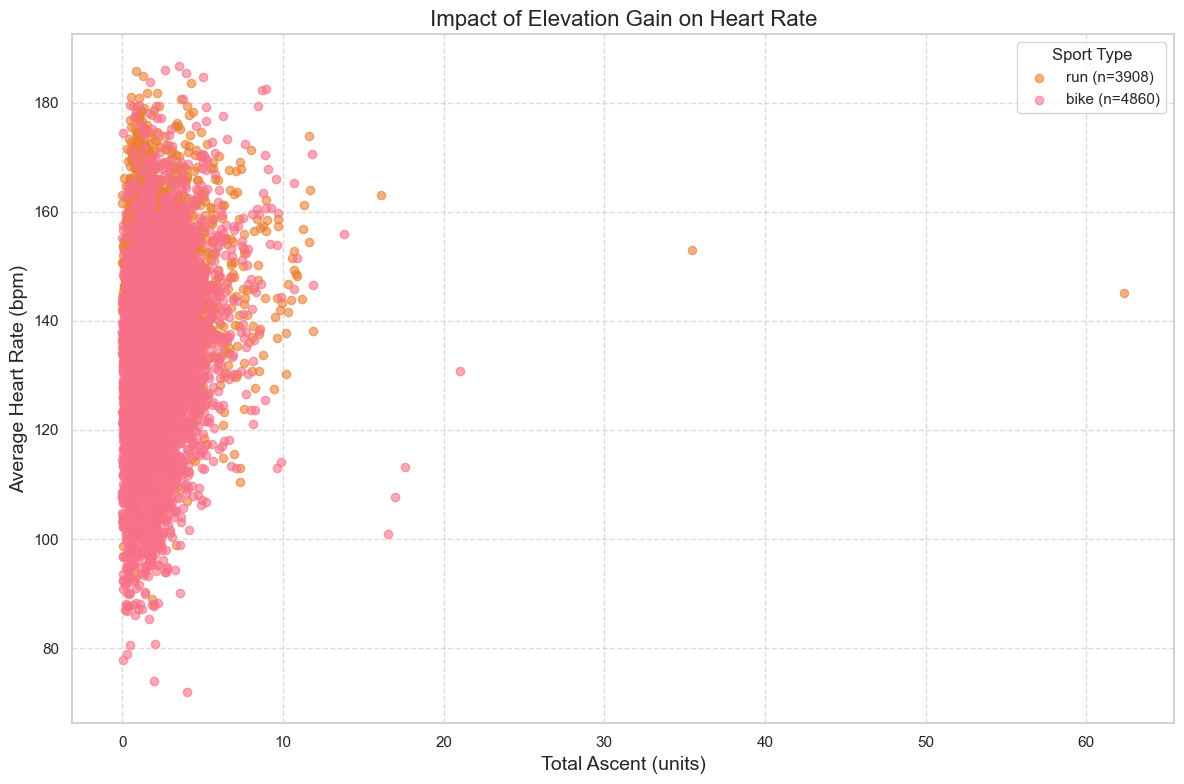

In [18]:
# 8. Altitude Analysis - Effect on Heart Rate

# Filter for workouts with altitude data
altitude_df = workouts_df.dropna(subset=['total_ascent', 'avg_hr'])

plt.figure(figsize=(12, 8))
for sport in ['run', 'bike', 'hike']:  # Focus on outdoor sports
    sport_data = altitude_df[altitude_df['sport'] == sport]
    if len(sport_data) > 10:
        plt.scatter(sport_data['total_ascent'], sport_data['avg_hr'], 
                    label=f"{sport} (n={len(sport_data)})", 
                    color=sport_colors.get(sport, 'gray'), alpha=0.6)

plt.title('Impact of Elevation Gain on Heart Rate', fontsize=16)
plt.xlabel('Total Ascent (units)', fontsize=14)
plt.ylabel('Average Heart Rate (bpm)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Sport Type')
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

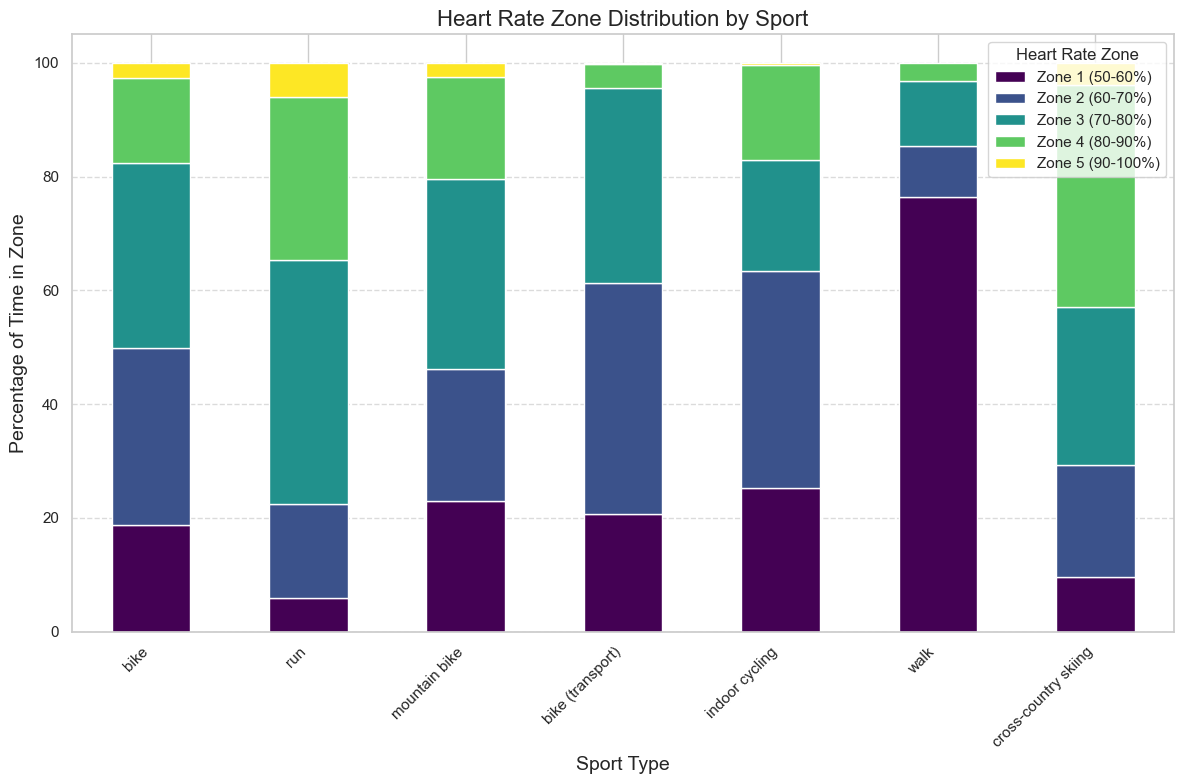

In [19]:
# 10. Advanced Analysis - Heart Rate Distribution Patterns

# Define function to calculate heart rate zone distribution
def hr_zone_distribution(hr_values, max_hr=190):
    """Calculate percentage of time spent in each heart rate zone"""
    zones = {
        'Zone 1 (50-60%)': 0,
        'Zone 2 (60-70%)': 0,
        'Zone 3 (70-80%)': 0,
        'Zone 4 (80-90%)': 0,
        'Zone 5 (90-100%)': 0
    }
    
    for hr in hr_values:
        hr_percent = hr / max_hr * 100
        if hr_percent < 60:
            zones['Zone 1 (50-60%)'] += 1
        elif hr_percent < 70:
            zones['Zone 2 (60-70%)'] += 1
        elif hr_percent < 80:
            zones['Zone 3 (70-80%)'] += 1
        elif hr_percent < 90:
            zones['Zone 4 (80-90%)'] += 1
        else:
            zones['Zone 5 (90-100%)'] += 1
    
    total = sum(zones.values())
    if total > 0:
        return {zone: count / total * 100 for zone, count in zones.items()}
    else:
        return zones

# Process a sample of workouts to get zone distributions
zone_data = []
sample_indices = np.random.choice(len(workouts_df), min(1000, len(workouts_df)), replace=False)

for idx in sample_indices:
    if 'hr_values' in workouts_df.iloc[idx]:
        workout = workouts_df.iloc[idx]
        zones = hr_zone_distribution(workout['hr_values'])
        zone_data.append({
            'sport': workout['sport'],
            **zones
        })

zone_df = pd.DataFrame(zone_data)

# Analyze zone distribution by sport
zone_by_sport = zone_df.groupby('sport').mean()
zone_by_sport = zone_by_sport.loc[top_sports]  # Filter for top sports

# Create a stacked bar chart
plt.figure(figsize=(14, 10))
zone_cols = [col for col in zone_df.columns if 'Zone' in col]
zone_by_sport[zone_cols].plot(kind='bar', stacked=True, 
                             colormap='viridis')

plt.title('Heart Rate Zone Distribution by Sport', fontsize=16)
plt.xlabel('Sport Type', fontsize=14)
plt.ylabel('Percentage of Time in Zone', fontsize=14)
plt.legend(title='Heart Rate Zone')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

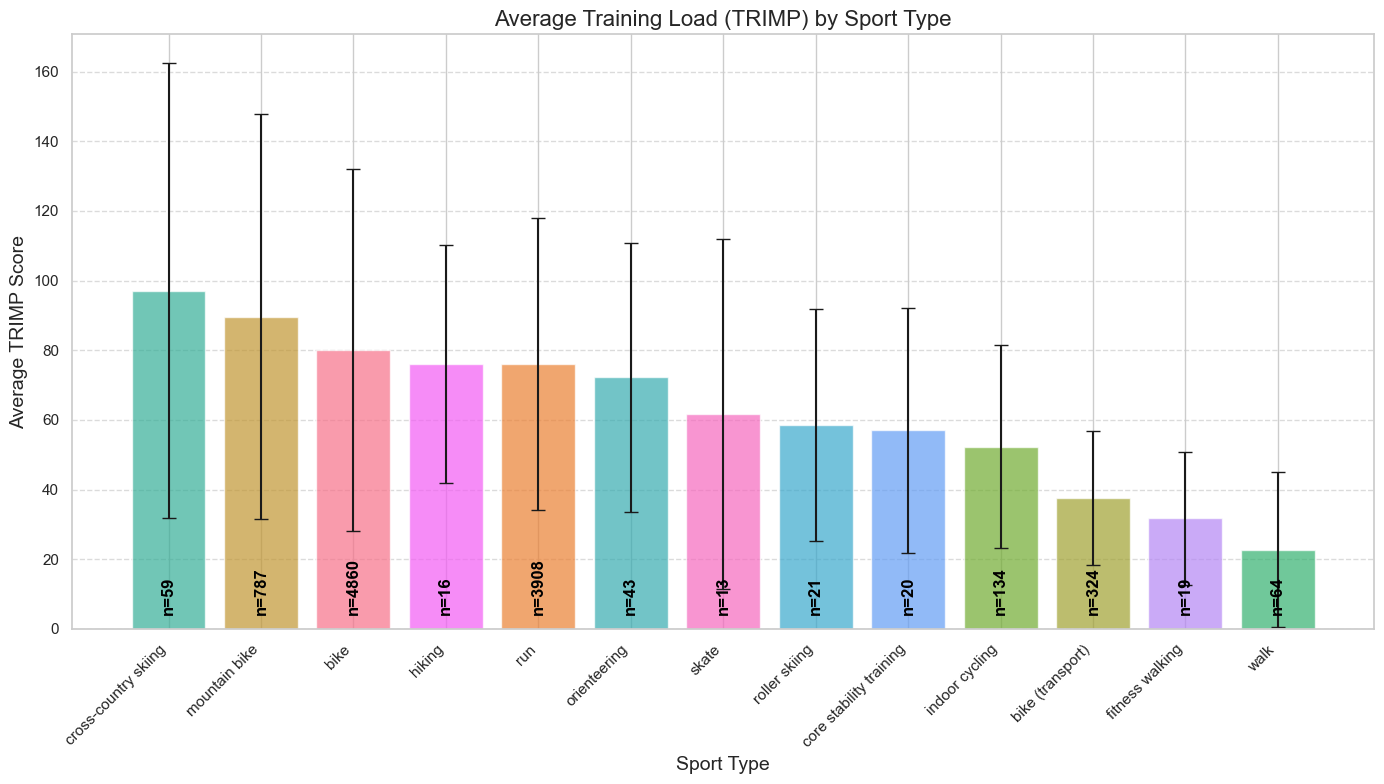

In [20]:
# 11. Training Load Analysis - Calculate TRIMP scores

# Simple Banister TRIMP calculation
def calculate_trimp(avg_hr, duration_min, gender='male', max_hr=190, rest_hr=60):
    """Calculate Training Impulse (TRIMP) score"""
    # Heart rate reserve (HRR)
    hrr = (avg_hr - rest_hr) / (max_hr - rest_hr)
    
    # Gender-specific factor
    if gender.lower() == 'female':
        k = 1.67
    else:
        k = 1.92
    
    # TRIMP formula
    trimp = duration_min * hrr * 0.64 * math.exp(k * hrr)
    return trimp

# Calculate TRIMP for workouts with duration
trimp_df = workouts_df.dropna(subset=['duration', 'avg_hr'])
trimp_df['duration_min'] = trimp_df['duration'] / 60
trimp_df['trimp'] = trimp_df.apply(
    lambda row: calculate_trimp(row['avg_hr'], row['duration_min'], row.get('gender', 'male')), 
    axis=1
)

# Analyze TRIMP by sport
trimp_by_sport = trimp_df.groupby('sport')['trimp'].agg(['mean', 'median', 'std', 'count'])
trimp_by_sport = trimp_by_sport[trimp_by_sport['count'] >= 10].sort_values('mean', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(trimp_by_sport.index, trimp_by_sport['mean'], 
               yerr=trimp_by_sport['std'], capsize=5, alpha=0.7,
               color=[sport_colors.get(s, 'gray') for s in trimp_by_sport.index])

plt.title('Average Training Load (TRIMP) by Sport Type', fontsize=16)
plt.xlabel('Sport Type', fontsize=14)
plt.ylabel('Average TRIMP Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels
for i, bar in enumerate(bars):
    count = trimp_by_sport['count'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, 5, 
             f'n={count}', ha='center', rotation=90, 
             color='black', fontweight='bold')

plt.tight_layout()
plt.show()